In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
np.random.seed(4747)

## Introducing, A Fully-Connected NN Model to Predict Temperature-anomaly based off Latitude, Longitude, Elevation, Species, Year, and d18O.

In [211]:
df = pd.read_csv('../../data_with_temp/all_coral_with_temp_fixed_1880-2012.csv')
df = df.drop('Unnamed: 0.1', 1)
# df = df.drop('Unnamed: 0', 1)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom
0,0,11.170000,119.150000,-4,Montastaea faveolata,1927,-4.067500,-0.405418
1,1,11.170000,119.150000,-4,Montastaea faveolata,1928,-3.865000,-0.503512
2,2,11.170000,119.150000,-4,Montastaea faveolata,1929,-3.865000,-0.819141
3,3,11.170000,119.150000,-4,Montastaea faveolata,1930,-4.007500,-0.337399
4,4,11.170000,119.150000,-4,Montastaea faveolata,1931,-4.040000,-0.099585
...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456


Fixing typos acquired from the original text scraping.

In [212]:
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Montastaea faveolata",
                 value ="Montastraea faveolata")
df = df.replace(to_replace ="Montastraea faviolata",
                 value ="Montastraea faveolata")         
df = df.replace(to_replace ="Porites australiensis",
                 value ="Porites australiensus") 
         

One-hot encoding of the species.

In [213]:
encoder_df = pd.get_dummies(df[['species']], prefix='species')
df = df.join(encoder_df)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0,11.170000,119.150000,-4,Montastraea faveolata,1927,-4.067500,-0.405418,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11.170000,119.150000,-4,Montastraea faveolata,1928,-3.865000,-0.503512,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11.170000,119.150000,-4,Montastraea faveolata,1929,-3.865000,-0.819141,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11.170000,119.150000,-4,Montastraea faveolata,1930,-4.007500,-0.337399,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,11.170000,119.150000,-4,Montastraea faveolata,1931,-4.040000,-0.099585,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579,0,0,...,0,0,0,0,0,1,0,0,0,0
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014,0,0,...,0,0,0,0,0,1,0,0,0,0
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223,0,0,...,0,0,0,0,0,1,0,0,0,0
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456,0,0,...,0,0,0,0,0,1,0,0,0,0


Now, we want to predict `temp`, given `species`, `year`, `d18O`, `lat`, and `long`.

First, let's configure all the data into one big dataframe. But only for years after 1960 (those are the temperature years we're pretty sure about). We will want to save the data with years before 1960 as part of our test data.

Then, let's scale everything between 1 and 0 to make it more suitable for the neural network.

In [214]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_1960 = df[df['year']<2021]
df_1960 = df_1960[df_1960['year']>1959]

df_1960 = df_1960.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_1960 = df_1960.reset_index()
df_1960 = df_1960.drop(columns = ['index'])
df_1960 

X = df_1960[cols_to_use]
Y = df_1960['temp_anom']

In [215]:
X = X.reset_index()
X = X.drop(columns = ['index'])
X 

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.170000,119.150000,-4,-3.777500,1960,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.170000,119.150000,-4,-4.152500,1961,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.170000,119.150000,-4,-4.022500,1962,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.170000,119.150000,-4,-3.672500,1963,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.170000,119.150000,-4,-3.912500,1964,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,20.666667,296.833333,-5,-5.474000,2008,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2865,20.666667,296.833333,-5,-5.249917,2009,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2866,20.666667,296.833333,-5,-5.299417,2010,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2867,20.666667,296.833333,-5,-5.397417,2011,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Remove any missing/filler data points for `year` and `elevation`.

In [216]:
X = X[X['year'].notna()]
X = X[X['year']!='-999']
X = X[X['year']!='NAN']

X = X[X['elevation'].notna()]
X = X[X['elevation']!='-999']
X = X[X['elevation']!='NAN']
X['elevation'] = X['elevation'].apply(lambda x: x.strip('m'))

X['elevation'] = X['elevation'].apply(lambda x: float(x))
X['year'] = X['year'].apply(lambda x: float(x))

Scale all the input variables between -1 and 1.

In [217]:
from sklearn import preprocessing

In [218]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X.columns
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=cols)
# standardize the year separately
X_scaled['year'] = (X['year'] - 1946) / 66
X_scaled.head()


,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.026103,0.212121,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.107760,0.227273,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.079452,0.242424,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.003239,0.257576,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.055500,0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [219]:
Y = Y.reset_index()
Y = Y.drop(columns = ['index'])
Y 

,temp_anom
0,-0.284105
1,-0.504643
2,-0.531974
3,-0.755829
4,-0.417459
...,...
2864,0.210579
2865,0.288014
2866,0.664223
2867,0.425456


Let's train a model to predict temp within the range 1960 - 2012.

In [220]:
from sklearn.model_selection import train_test_split
X_train_80, X_val_and_test_20, Y_train_80, Y_val_and_test_20 = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=47)

In [221]:
X_val_and_test_20.shape, Y_val_and_test_20.shape

((574, 25), (574, 1))

In [222]:
X_val_and_test_20.index, Y_val_and_test_20.index

(Int64Index([ 462, 2305,  366, 1031, 1868,  633, 1437, 1793, 1110, 2051,
             ...
              133,  408,  742,  185,  305,   71, 2576, 2150, 2789, 1155],
            dtype='int64', length=574),
 Int64Index([ 462, 2305,  366, 1031, 1868,  633, 1437, 1793, 1110, 2051,
             ...
              133,  408,  742,  185,  305,   71, 2576, 2150, 2789, 1155],
            dtype='int64', length=574))

In [223]:
X_train_80.shape, Y_train_80.shape

((2295, 25), (2295, 1))

In [224]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [225]:
from numpy.random import seed
seed(47)

## Full-Connected Neural Network

Next, we are going to tune a Fully-Connected NN (deep NN) using cross validation of differen parameter values. 

In [22]:
# def build_model(layer1_units, layer2_units, layer3_units, 
#                 dropout_rate):
#     # create layers of the NN
#     network = Sequential()

#     #input layer
#     network.add(Dense(layer1_units, input_shape=(25,), activation='LeakyReLU'))

#     #middle layers
#     network.add(Dense(layer2_units, activation='LeakyReLU'))
#     network.add(Dropout(dropout_rate))

#     network.add(Dense(layer2_units, activation='LeakyReLU'))

#     network.add(Dense(layer3_units, activation='LeakyReLU'))
#     network.add(Dropout(dropout_rate))

#     #output layer
#     network.add(Dense(1, activation='LeakyReLU'))

#     network.compile('adam', loss='mse', metrics=['mse'])

#     return network

In [23]:
# from keras.wrappers.scikit_learn import KerasRegressor
# model = KerasRegressor(build_fn=build_model)

In [15]:
# from sklearn.model_selection import GridSearchCV

# params={'batch_size':[300, 100, 50, 25, 10], 
#         'nb_epoch':[25, 50, 75, 100],
#         'layer1_units':[4, 6, 8, 10],
#         'layer2_units':[2, 4, 6, 8],
#         'layer3_units':[2, 4, 6, 8],
#         'dropout_rate':[0.1, 0.2, 0.25],
#         }
# gs=GridSearchCV(estimator=model, param_grid=params, cv=8)
# # now fit the dataset to the GridSearchCV object. 
# gs = gs.fit(X_scaled, Y)

In [16]:
# best_params=gs.best_params_
# accuracy=gs.best_score_

Original (Untuned) Network below!

In [226]:
network = Sequential()

#input layer
network.add(Dense(8, input_shape=(25,), activation='LeakyReLU'))

#middle layers
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dropout(0.2))

network.add(Dense(6, activation='LeakyReLU'))

network.add(Dense(4, activation='LeakyReLU'))
network.add(Dropout(0.2))

#output layer
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
network.fit(X_scaled, Y, epochs=50)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.1366 - mse: 0.1366
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1281 - mse: 0.1281
Epoch 3/50
90/90 [==============================] - 0s 995us/step - loss: 0.1267 - mse: 0.1267
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.1259 - mse: 0.1259
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1248 - mse: 0.1248
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1242 - mse: 0.1242
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1219 - mse: 0.1219
Epoch 8/50
90/90 [==============================] - 0s 980us/step - loss: 0.1215 - mse: 0.1215
Epoch 9/50
90/90 [==============================] - 0s 975us/step - loss: 0.1178 - mse: 0.1178
Epoch 10/50
90/90 [==============================] - 0s 972us/step - loss: 0.1134 - mse: 0.1134
Epoch 11/50
90/90 [==============================] - 0s 963us

In [149]:
network.evaluate(X_val_and_test_20, Y_val_and_test_20)

18/18 [==============================] - 0s 2ms/step - loss: 0.1152 - mse: 0.1152


[0.11524593830108643, 0.11524593830108643]

This network with a dropout layer produces a teeny loss, maybe we're overfitting?

In [227]:
actual_all = pd.DataFrame(Y_val_and_test_20, columns=["temp_anom"])
predicted_all = pd.DataFrame(network.predict(X_val_and_test_20), columns=["pred"])
actual_all.head(), predicted_all.head()

(      temp_anom
 462   -0.295150
 2305   0.049835
 366   -0.409911
 1031  -0.519731
 1868  -1.026064,
        pred
 0 -0.188893
 1 -0.082773
 2  0.078024
 3 -0.303277
 4 -0.186702)

In [228]:
predicted_all['index'] = actual_all.index
predicted_all = predicted_all.set_index(['index'])
predicted_all['index'] = actual_all.index
predicted_all = predicted_all.set_index(['index'])
predicted_all

,pred
index,
462,-0.188893
2305,-0.082773
366,0.078024
1031,-0.303277
1868,-0.186702
...,...
71,-0.296654
2576,-0.043423
2150,0.016900


In [229]:
actual_v_pred_all = actual_all.join(predicted_all, how = "inner")
actual_v_pred_all

,temp_anom,pred
462,-0.295150,-0.188893
2305,0.049835,-0.082773
366,-0.409911,0.078024
1031,-0.519731,-0.303277
1868,-1.026064,-0.186702
...,...,...
71,0.124114,-0.296654
2576,-0.130982,-0.043423
2150,-0.276287,0.016900
2789,-0.515850,-0.315285


In [230]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_val_and_test_20, predicted_all)

0.08231011038353817

In [231]:
test_data_with_preds = actual_v_pred_all.join(X_val_and_test_20, how = "inner")
test_data_with_preds['diff'] = test_data_with_preds['temp_anom'] - test_data_with_preds['pred']
test_data_with_preds

,temp_anom,pred,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
462,-0.295150,-0.188893,0.767377,-0.519790,0.729323,0.008193,0.424242,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.106257
2305,0.049835,-0.082773,-0.617856,1.000000,0.849624,0.739840,0.651515,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.132608
366,-0.409911,0.078024,0.762552,-0.521235,0.849624,0.502491,0.696970,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.487935
1031,-0.519731,-0.303277,-0.756051,0.273618,0.694737,-0.201938,0.272727,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.216454
1868,-1.026064,-0.186702,0.457505,0.922722,1.000000,-0.253110,0.287879,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.839362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.124114,-0.296654,0.484750,-0.184135,0.834586,0.064990,0.227273,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.420769
2576,-0.130982,-0.043423,0.126835,-0.999924,0.744361,-0.316466,0.545455,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.087559
2150,-0.276287,0.016900,-0.016494,0.681278,0.834586,-0.343462,0.575758,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-0.293186
2789,-0.515850,-0.315285,0.126953,-0.999982,0.729323,-0.253654,0.272727,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.200565


Text(0, 0.5, 'Predicted')

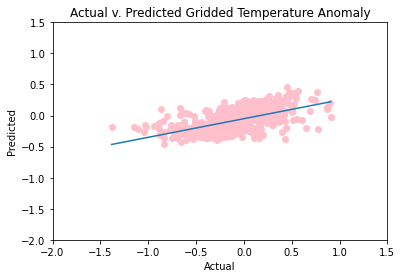

In [232]:
x = test_data_with_preds['temp_anom']
y = test_data_with_preds['pred']
plt.scatter(test_data_with_preds['temp_anom'], test_data_with_preds['pred'], color="pink")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlim([-2, 1.5])
plt.ylim([-2, 1.5])
plt.title('Actual v. Predicted Gridded Temperature Anomaly')
plt.xlabel('Actual')
plt.ylabel('Predicted')

Text(0, 0.5, 'Temp Error')

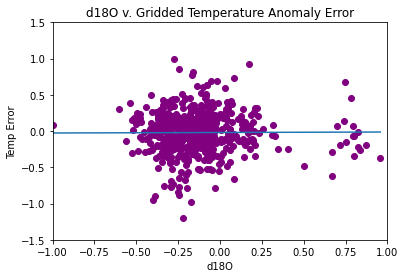

In [233]:
x = test_data_with_preds['d18o']
y = test_data_with_preds['diff']
plt.scatter(test_data_with_preds['d18o'], test_data_with_preds['diff'], color="purple")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlim([-1, 1])
plt.ylim([-1.5, 1.5])
plt.title('d18O v. Gridded Temperature Anomaly Error')
plt.xlabel('d18O')
plt.ylabel('Temp Error')

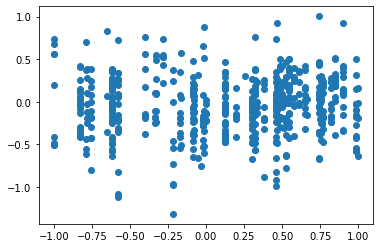

In [157]:
plt.scatter(test_data_with_preds['lat'], test_data_with_preds['diff'])

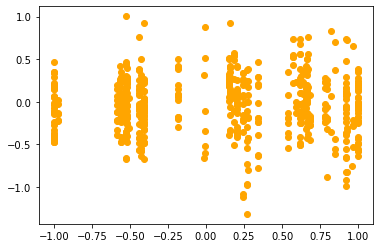

In [158]:
plt.scatter(test_data_with_preds['lon'], test_data_with_preds['diff'], color="orange")

Let's now take all of our predictions, average them by year

<AxesSubplot:>

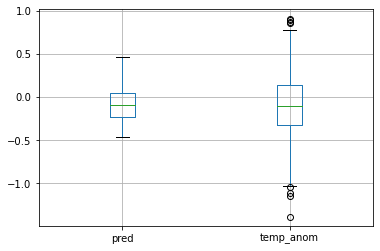

In [234]:
test_data_with_preds.boxplot(column = ['pred', 'temp_anom'])

In [235]:
annual_temp_and_preds = test_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare.head()

<ipython-input-235-ad8139a92e35>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,1960.0,-0.214776,-0.320061
1,1961.0,-0.292462,-0.293913
2,1962.0,-0.312866,-0.272915
3,1963.0,-0.273694,-0.304059
4,1964.0,-0.469671,-0.277239


([<matplotlib.lines.Line2D at 0x7fc39bace670>],
 [<matplotlib.lines.Line2D at 0x7fc39ba35640>])

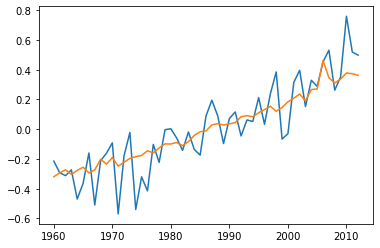

In [236]:
plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Sweet --- looks like we've at least followed the general trend of global warming :)

In [237]:
np.corrcoef(annual_compare['temp_anom'], annual_compare['pred'])

array([[1.        , 0.88612135],
       [0.88612135, 1.        ]])

In [238]:
np.var(annual_compare['temp_anom']), np.var(annual_compare['pred'])

(0.08821661774356568, 0.04735681414604187)

We should note that our predictions do not vary as much as the actual values.

In [ ]:
# annual_compare.to_csv('preds_1960-2012_WITHIN.csv')

### Let's see how our model performs on the years prior to 1960.

In [239]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_past = df[df['year']<1960]

df_past = df_past.dropna()
df_past = df_past.reset_index()
df_past = df_past.drop(columns = ['index'])
df_past 

X_past = df_past[cols_to_use]
Y_past = df_past['temp_anom']

In [240]:
X_past = X_past.reset_index()
X_past = X_past.drop(columns = ['index'])
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4,-4.067500,1927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4,-3.865000,1928,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4,-3.865000,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4,-4.007500,1930,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4,-4.040000,1931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10,-4.753333,1955,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10,-4.785000,1956,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10,-4.924167,1957,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10,-5.017500,1958,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [241]:
X_past = X_past[X_past['year'].notna()]
X_past = X_past[X_past['year']!='-999']
X_past = X_past[X_past['year']!='NAN']

X_past = X_past[X_past['elevation'].notna()]
X_past = X_past[X_past['elevation']!='-999']
X_past = X_past[X_past['elevation']!='NAN']
X_past['elevation'] = X_past['elevation'].apply(lambda x: x.strip('m'))

X_past['elevation'] = X_past['elevation'].apply(lambda x: float(x))
X_past['year'] = X_past['year'].apply(lambda x: float(x))
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4.0,-4.067500,1927.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4.0,-3.865000,1928.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4.0,-3.865000,1929.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4.0,-4.007500,1930.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4.0,-4.040000,1931.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10.0,-4.753333,1955.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10.0,-4.785000,1956.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10.0,-4.924167,1957.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10.0,-5.017500,1958.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [242]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

og_year = X_past['year']

cols = X_past.columns
d = scaler.fit_transform(X_past)
X_past = pd.DataFrame(d, columns=cols)
X_past['year'] = (og_year -1946)/66
X_past.head()

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.300928,-0.406596,0.819549,-0.445162,-0.287879,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.300928,-0.406596,0.819549,-0.397605,-0.272727,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.300928,-0.406596,0.819549,-0.397605,-0.257576,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.300928,-0.406596,0.819549,-0.431071,-0.242424,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.300928,-0.406596,0.819549,-0.438704,-0.227273,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [243]:
Y_past = Y_past.reset_index()
Y_past = Y_past.drop(columns = ['index'])
Y_past 

,temp_anom
0,-0.405418
1,-0.503512
2,-0.819141
3,-0.337399
4,-0.099585
...,...
4025,-0.679975
4026,-0.700354
4027,-0.415288
4028,-0.047501


Use this functionality to convert `X_past` and `Y_past` from `nparrays` to `tensors`

In [244]:
network.predict(X_past)

array([[-0.7759127 ],
       [-0.7637099 ],
       [-0.7521941 ],
       ...,
       [-0.37890485],
       [-0.36688274],
       [-0.35586774]], dtype=float32)

In [245]:
actual_past = pd.DataFrame(Y_past, columns=["temp_anom"])
predicted_past = pd.DataFrame(network.predict(X_past), columns=["pred"])
actual_past.head(), predicted_past.head()

(   temp_anom
 0  -0.405418
 1  -0.503512
 2  -0.819141
 3  -0.337399
 4  -0.099585,
        pred
 0 -0.775913
 1 -0.763710
 2 -0.752194
 3 -0.741161
 4 -0.729756)

In [246]:
network.evaluate(X_past, Y_past)

126/126 [==============================] - 0s 1ms/step - loss: 0.2227 - mse: 0.2227


[0.22270788252353668, 0.22270788252353668]

We have a much larger `test` loss than we did within the ranges of our training bounds. 

In [247]:
actual_v_pred_past = actual_past.join(predicted_past, how = "inner")
actual_v_pred_past

,temp_anom,pred
0,-0.405418,-0.775913
1,-0.503512,-0.763710
2,-0.819141,-0.752194
3,-0.337399,-0.741161
4,-0.099585,-0.729756
...,...,...
4025,-0.679975,-0.402835
4026,-0.700354,-0.391257
4027,-0.415288,-0.378905
4028,-0.047501,-0.366883


In [248]:
past_data_with_preds = actual_v_pred_past.join(X_past, how = "inner")
past_data_with_preds['diff'] = actual_v_pred_past['temp_anom'] - actual_v_pred_past['pred']
past_data_with_preds

,temp_anom,pred,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
0,-0.405418,-0.775913,0.300928,-0.406596,0.819549,-0.445162,-0.287879,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.370495
1,-0.503512,-0.763710,0.300928,-0.406596,0.819549,-0.397605,-0.272727,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.260198
2,-0.819141,-0.752194,0.300928,-0.406596,0.819549,-0.397605,-0.257576,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.066947
3,-0.337399,-0.741161,0.300928,-0.406596,0.819549,-0.431071,-0.242424,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.403762
4,-0.099585,-0.729756,0.300928,-0.406596,0.819549,-0.438704,-0.227273,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.630171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,-0.679975,-0.402835,0.126953,-0.999982,0.729323,-0.606231,0.136364,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.277140
4026,-0.700354,-0.391257,0.126953,-0.999982,0.729323,-0.613668,0.151515,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.309098
4027,-0.415288,-0.378905,0.126953,-0.999982,0.729323,-0.646352,0.166667,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.036383
4028,-0.047501,-0.366883,0.126953,-0.999982,0.729323,-0.668271,0.181818,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.319382


([<matplotlib.lines.Line2D at 0x7fc39d467a30>],
 [<matplotlib.lines.Line2D at 0x7fc39d467dc0>])

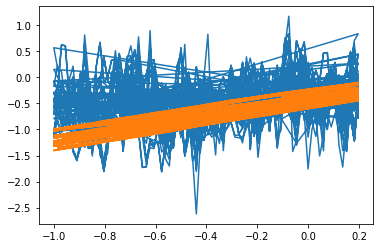

In [249]:
plt.plot(past_data_with_preds['year'], past_data_with_preds['temp_anom']), plt.plot(past_data_with_preds['year'], past_data_with_preds['pred'])

In [250]:
annual_temp_and_preds = past_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare_past = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare_past

<ipython-input-250-fa6798582bda>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare_past = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,-1.000000,-0.580696,-1.179370
1,-0.984848,-0.437284,-1.180906
2,-0.969697,-0.448660,-1.163842
3,-0.954545,-0.535872,-1.157540
4,-0.939394,-0.577859,-1.140669
...,...,...,...
75,0.136364,-0.628892,-0.359786
76,0.151515,-0.655931,-0.349440
77,0.166667,-0.272213,-0.339182
78,0.181818,-0.251039,-0.326393


In [251]:
annual_compare_past['year'] = np.arange(1880, 1960, 1)
annual_compare_past

,year,temp_anom,pred
0,1880,-0.580696,-1.179370
1,1881,-0.437284,-1.180906
2,1882,-0.448660,-1.163842
3,1883,-0.535872,-1.157540
4,1884,-0.577859,-1.140669
...,...,...,...
75,1955,-0.628892,-0.359786
76,1956,-0.655931,-0.349440
77,1957,-0.272213,-0.339182
78,1958,-0.251039,-0.326393


([<matplotlib.lines.Line2D at 0x7fc39ea21310>],)

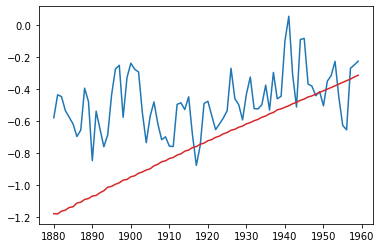

In [266]:
plt.plot(annual_compare_past['year'], annual_compare_past['temp_anom'], color = 'C0') #actual
plt.plot(annual_compare_past['year'], annual_compare_past['pred'], color = 'C3'),  #pred

In [302]:
np.corrcoef(annual_compare_past['temp_anom'], annual_compare_past['pred'])

array([[1.        , 0.40015649],
       [0.40015649, 1.        ]])

In [305]:
np.var(annual_compare_past['temp_anom']), np.var(annual_compare_past['pred'])

(0.032962245549201914, 0.06438331305980682)

In [ ]:
mean_squared_error(annual_compare_past['temp_anom'], annual_compare_past['pred'])

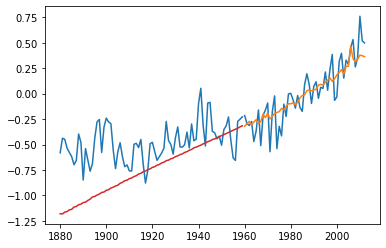

In [265]:
plt.plot(annual_compare['year'], annual_compare['temp_anom'], color = 'C0') # actual 
plt.plot(annual_compare['year'], annual_compare['pred'], color = 'C1') # prediction
plt.plot(annual_compare_past['year'], annual_compare_past['temp_anom'], color = 'C0')# actual
plt.plot(annual_compare_past['year'], annual_compare_past['pred'], color = 'C3') # prediction

Our network very much over-predicted the `temp_anom`. Probably because it over-fit to the training data which had higher temp anomalies.

In [179]:
# annual_compare.to_csv('../../models/fully_connected_nn/preds_1880-1960_OUTSIDE.csv')

In [292]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

# years from 1880 - 2020
df_all = df[df['year']<2021]
df_all = df_all[df_all['year']>1879]

# remove bad years
df_all = df_all[df_all['year'].notna()]
df_all = df_all[df_all['year']!='-999']
df_all = df_all[df_all['year']!='NAN']
df_all['year'] = df_all['year'].apply(lambda x: float(x))

df_all = df_all.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_all = df_all.reset_index()
df_all = df_all.drop(columns = ['index'])

# just grab the columns we want for the linear model
df_linear = df_all[['year', 'd18o', 'temp_anom']]
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

df_linear['d18o_scaled'] = scaler.fit_transform(df_linear['d18o'].values.reshape(-1, 1))

df_linear['linear_prediction'] = (df_linear['d18o_scaled'] / -0.22) - 1.5
df_linear
# df_all

<ipython-input-292-4ad0ad0194a9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear['d18o_scaled'] = scaler.fit_transform(df_linear['d18o'].values.reshape(-1, 1))
<ipython-input-292-4ad0ad0194a9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear['linear_prediction'] = (df_linear['d18o_scaled'] / -0.22) - 1.5


,year,d18o,temp_anom,d18o_scaled,linear_prediction
0,1927.0,-4.067500,-0.405418,-0.190693,-0.633215
1,1928.0,-3.865000,-0.503512,-0.151509,-0.811321
2,1929.0,-3.865000,-0.819141,-0.151509,-0.811321
3,1930.0,-4.007500,-0.337399,-0.179083,-0.685987
4,1931.0,-4.040000,-0.099585,-0.185372,-0.657402
...,...,...,...,...,...
6894,2008.0,-5.474000,0.210579,-0.462848,0.603856
6895,2009.0,-5.249917,0.288014,-0.419489,0.406766
6896,2010.0,-5.299417,0.664223,-0.429067,0.450303
6897,2011.0,-5.397417,0.425456,-0.448030,0.536498


In [293]:
annual_compare_linear = df_linear.groupby('year', as_index=False)['temp_anom', 'linear_prediction'].mean()
annual_compare_linear

<ipython-input-293-98a9c417d4e7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare_linear = df_linear.groupby('year', as_index=False)['temp_anom', 'linear_prediction'].mean()


,year,temp_anom,linear_prediction
0,1880.0,-0.580696,-0.476803
1,1881.0,-0.437284,-0.601032
2,1882.0,-0.448660,-0.557324
3,1883.0,-0.535872,-0.632149
4,1884.0,-0.577859,-0.554055
...,...,...,...
129,2009.0,0.393781,0.266237
130,2010.0,0.826230,0.389430
131,2011.0,0.408003,0.321495
132,2012.0,0.520382,0.478369


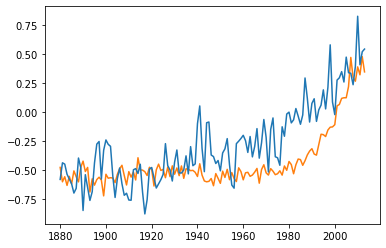

In [294]:
plt.plot(annual_compare_linear['year'], annual_compare_linear['linear_prediction'], color = 'C1') # prediction
plt.plot(annual_compare_linear['year'], annual_compare_linear['temp_anom'], color = 'C0') # prediction


In [297]:
np.corrcoef(annual_compare_linear['linear_prediction'], annual_compare_linear['temp_anom'])

array([[1.        , 0.78049672],
       [0.78049672, 1.        ]])

In [300]:
np.var(annual_compare_linear['temp_anom']), np.var(annual_compare_linear['linear_prediction'])

(0.11668802764548811, 0.06242333467653779)

In [301]:
mean_squared_error(annual_compare_linear['temp_anom'],annual_compare_linear['linear_prediction'])

0.06841243399563134